In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
# from pmdarima import auto_arima
import joblib
import datetime

In [3]:
filename = 'table_values_csv.csv'
df = pd.read_csv(filename, sep=',',low_memory=False)
display(df.head())

,id_x,due_date,new_due_date,created_at,updated_at,number,value,nfe_number,nfe_series,kind_x,...,document_number,authorized_third_party_id,company_name,kind_y,paymaster_id,ballast_kind,invoice_number,payment_place,update_reason_kind,finished_at
0,b13369ca-e3de-451c-bfa0-2c2c06db00da,2023-08-05,2023-08-05,2023-07-12 13:38:12.047933,2023-07-12 13:38:12.061655,003123,0.01,523451,6,services,...,1.394248e+13,NaN,"Ramalho, Macieira e Caldeira",registration_participant,NaN,invoice,123123,São Paulo,others,NaN
1,c2f7a256-7165-4787-966e-e094344827d8,2024-03-23,2024-03-23,2024-02-07 19:34:32.485735,2024-02-07 19:34:32.485735,2,2014.09,000005010,001,goods,...,1.394248e+13,NaN,"Ramalho, Macieira e Caldeira",registration_participant,NaN,nfe_key,NaN,BA,others,NaN
2,1bedeb72-2413-43ec-95a9-c6b539ce6a99,2024-01-17,2024-01-17,2023-12-20 13:22:01.374323,2023-12-20 13:22:01.374323,1,1047.74,000038412,001,goods,...,9.153087e+13,NaN,Gabeira-Mangueira,registration_participant,NaN,nfe_key,NaN,RN,NaN,NaN
3,ac2d5831-fdd6-44c5-8b07-01faa04dc451,2023-07-31,2023-07-31,2023-06-29 17:54:29.988490,2023-06-29 17:54:29.988490,3932,59.83,3932,1,goods,...,9.409448e+13,NaN,Cardoso LTDA,registration_participant,NaN,nfe_key,NaN,teste,operational_error,NaN
4,dacc7c5a-accb-430b-8d51-5aceb572e2c4,2033-08-05,2033-08-05,2024-02-07 18:56:32.251144,2024-02-07 18:56:32.256128,910304872,0.01,910304872,910304872,goods,...,1.394248e+13,NaN,"Ramalho, Macieira e Caldeira",registration_participant,NaN,nfe_key,NaN,São Paulo,others,NaN


In [8]:
# Converte a coluna para o tipo datetime, caso não esteja
import datetime

df['created_at'] = pd.to_datetime(df['created_at'])

# Extrai o mês da coluna de datas
df['mes_referencia'] = df['created_at'].dt.month
df['dia_do_mes'] = df['created_at'].dt.day

# Criando uma coluna para categorizar os registros em "antes do dia 15" e "após o dia 15"
df['periodo_mes'] = df['dia_do_mes'].apply(lambda x: 'antes_15' if x <= 15 else 'apos_15')

# Agora podemos agrupar por mês e período (antes ou após o dia 15) e contar os registros (total_registros)
df_mensal = df.groupby(['mes_referencia']).agg(
    total_registros=('id_x', 'size')
).reset_index()

df_mensal = df_mensal[~df_mensal['mes_referencia'].isin([9, 10, 11, 12])]

display(df_mensal)


,mes_referencia,total_registros
0,1,3208
1,2,26003
2,3,114707
3,4,12250
4,5,4673
5,6,7319
6,7,5499
7,8,7471


In [11]:
# Escolher a ordem do modelo (p,d,q) - Ex: (1,1,0))
modelo = ARIMA(df_mensal['total_registros'], order=(1,1,0))
model_fit = modelo.fit()

#Previsão do proximo mes
forecast = model_fit.forecast(steps=2)
previsao = [1, 2]
forecast_df = pd.DataFrame({'previsao_id': previsao, 'predicted_population': forecast})
forecast_df.set_index('mes_referencia', inplace=True)

forecast_df = forecast_df.astype(int)
display(forecast_df)

,predicted_population
mes_referencia,
9,6821
10,7035


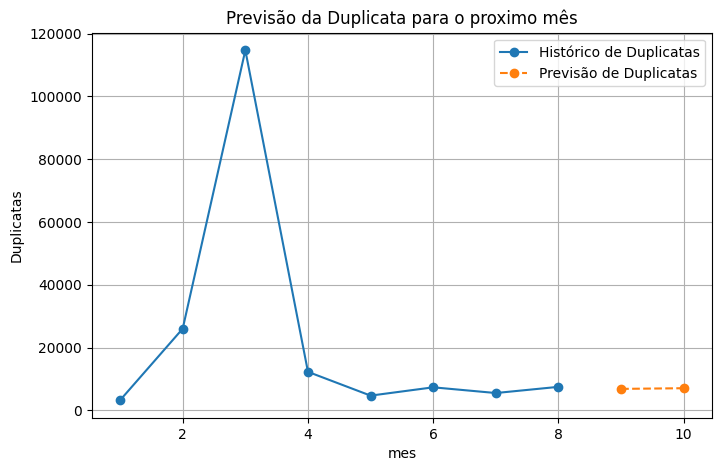

In [13]:
# Visualização dos Resultados
plt.figure(figsize=(8, 5))
plt.plot(df_mensal.set_index('mes_referencia'), label='Histórico de Duplicatas', marker='o')
plt.plot(forecast_df, label='Previsão de Duplicatas', linestyle='--', marker='o')
plt.xlabel('mes')
plt.ylabel('Duplicatas')
plt.title('Previsão da Duplicata para o proximo mês')
plt.legend()
plt.grid()
plt.show()

In [18]:
#Removendo os meses para teste
df_mensal_teste = df_mensal[~df_mensal['mes_referencia'].isin([6,7,8])]

# Escolher a ordem do modelo (p,d,q) - Ex: (1,1,0)
modelo = ARIMA(df_mensal_teste['total_registros'], order=(1,1,0))
model_fit = modelo.fit()

#Previsão do proximo mes
forecast = model_fit.forecast(steps=3)
future_month = [6, 7, 8]
forecast_df = pd.DataFrame({'mes_referencia': future_month, 'predicted_population': forecast})
forecast_df.set_index('mes_referencia', inplace=True)

forecast_df = forecast_df.astype(int)
display(forecast_df)
display(df_mensal)

,predicted_population
mes_referencia,
6,7165
7,6345
8,6615


,mes_referencia,total_registros
0,1,3208
1,2,26003
2,3,114707
3,4,12250
4,5,4673
5,6,7319
6,7,5499
7,8,7471


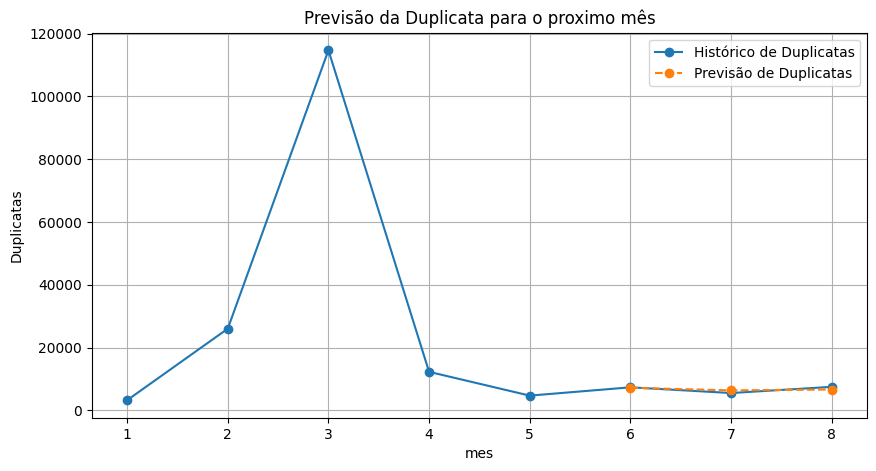

In [19]:
# Visualização dos Resultados
plt.figure(figsize=(10, 5))
plt.plot(df_mensal.set_index('mes_referencia'), label='Histórico de Duplicatas', marker='o')
plt.plot(forecast_df, label='Previsão de Duplicatas', linestyle='--', marker='o')
plt.xlabel('mes')
plt.ylabel('Duplicatas')
plt.title('Previsão da Duplicata para o proximo mês')
plt.legend()
plt.grid()
plt.show()